# Step 1 - 模型训练

现在我们对正在处理的数据有了一些感觉，可以开始设计我们的模型了。在本笔记本中，我们将定义网络架构并训练模型。我们还将讨论数据上的一些转换，以回应我们在笔记本的数据探索部分所做的观察。

让我们从导入一些库和定义一些路径开始。

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Lambda, Input, concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ELU
from keras.optimizers import Adam, SGD, Adamax, Nadam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, CSVLogger, EarlyStopping
import keras.backend as K
from keras.preprocessing import image

from keras_tqdm import TQDMNotebookCallback

import json
import os
import numpy as np
import pandas as pd
from Generator import DriveDataGenerator
from Cooking import checkAndCreateDir
import h5py
from PIL import Image, ImageDraw
import math
import matplotlib.pyplot as plt

# << 配置前一步预处理好的数据集目录 >>
COOKED_DATA_DIR = '../../../AirSim/EndToEndLearningRawData/data_cooked/'

# << 模型文件输出目录：随着梯度越来越小，模型会逐步更新 >>
MODEL_OUTPUT_DIR = 'model'

Using TensorFlow backend.


让我们读探索阶段的数据集。如果不存在，运行[上一步](dataexplorationandprepare .ipynb)笔记本中的代码片段来生成它们。

In [2]:
train_dataset = h5py.File(os.path.join(COOKED_DATA_DIR, 'train.h5'), 'r')
eval_dataset = h5py.File(os.path.join(COOKED_DATA_DIR, 'eval.h5'), 'r')
test_dataset = h5py.File(os.path.join(COOKED_DATA_DIR, 'test.h5'), 'r')

num_train_examples = train_dataset['image'].shape[0]
num_eval_examples = eval_dataset['image'].shape[0]
num_test_examples = test_dataset['image'].shape[0]

batch_size=32

对于图像数据，将整个数据集加载到内存中代价太大。幸运的是，Keras有DataGenerators的概念。DataGenerator只不过是一个迭代器，它将以块的形式从磁盘读取数据。这允许您保持您的CPU和GPU繁忙，增加吞吐量。
我们在探索阶段做了一些观察。现在，让我们想出一个策略，将它们纳入我们的训练算法:
- **只有图像的一小部分是感兴趣的（ROI）** -当生成批量时，我们可以删除图像中不感兴趣的部分。
- **数据集显示垂直翻转公差** -当生成批量时，我们可以随机翻转一些图像和Y轴周围的标签，以便模型有新的数据学习。
- **数据集应该对照明的变化保持不变** -当生成批量时，我们可以随机增加或删除图像的亮度，这样模型就可以知道照明的全局变化应该被忽略。
- **数据集有很高比例的零值图像** -当生成批量时，我们可以随机降低一个百分比的数据点，其中转向角度为零，这样模型在训练时看到一个平衡的数据集。
- **从我们的数据集中我们需要转向策略的例子，以便模型学习如何急剧转向** -我们在预处理阶段处理这个问题。
虽然Keras有一些标准的内置图像转换，但它们还不足以满足我们的目的。例如，当在标准的ImageDataGenerator中使用horizontal_flip = True时，标签的符号不会倒过来。幸运的是，我们可以扩展ImageDataGenerator类并实现我们自己的转换逻辑。这样做的代码在Generator.py中——它很简单，但是太长了，不能包含在本笔记本中。
这里，我们将用以下参数初始化生成器:
- **Zero_Drop_Percentage: 0.9**—也就是说，我们将随机丢弃标签为0的90%的数据点
- **Brighten_Range: 0.4** -也就是说，每个图像的亮度将被修改高达40%。为了计算“亮度”，我们将图像从RGB空间转换到HSV空间，将“V”坐标上下缩放，再转换回RGB空间。
- **ROI:[76,135,0,255]** -这是x1, x2, y1, y2矩形，表示图像感兴趣的区域。

**思考练习1.1**
试着摆弄一下这些参数，看看是否能得到更好的结果。


In [3]:
data_generator = DriveDataGenerator(rescale=1./255., horizontal_flip=True, brighten_range=0.4)
train_generator = data_generator.flow\
    (train_dataset['image'], train_dataset['previous_state'], train_dataset['label'], batch_size=batch_size, zero_drop_percentage=0.95, roi=[76,135,0,255])
eval_generator = data_generator.flow\
    (eval_dataset['image'], eval_dataset['previous_state'], eval_dataset['label'], batch_size=batch_size, zero_drop_percentage=0.95, roi=[76,135,0,255])    

让我们看看一批样品。转向角度用图中红线表示:

Actual Steering Angle = [-0.013753]


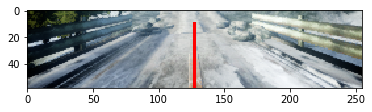

Actual Steering Angle = [-0.011759]


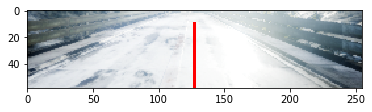

Actual Steering Angle = [-0.087036]


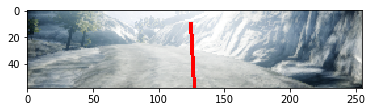

In [4]:
def draw_image_with_label(img, label, prediction=None):
    theta = label * 0.69 #Steering range for the car is +- 40 degrees -> 0.69 radians
    line_length = 50
    line_thickness = 3
    label_line_color = (255, 0, 0)
    prediction_line_color = (0, 0, 255)
    pil_image = image.array_to_img(img, K.image_data_format(), scale=True)
    print('Actual Steering Angle = {0}'.format(label))
    draw_image = pil_image.copy()
    image_draw = ImageDraw.Draw(draw_image)
    first_point = (int(img.shape[1]/2),img.shape[0])
    second_point = (int((img.shape[1]/2) + (line_length * math.sin(theta))), int(img.shape[0] - (line_length * math.cos(theta))))
    image_draw.line([first_point, second_point], fill=label_line_color, width=line_thickness)
    
    if (prediction is not None):
        print('Predicted Steering Angle = {0}'.format(prediction))
        print('L1 Error: {0}'.format(abs(prediction-label)))
        theta = prediction * 0.69
        second_point = (int((img.shape[1]/2) + (line_length * math.sin(theta))), int(img.shape[0] - (line_length * math.cos(theta))))
        image_draw.line([first_point, second_point], fill=prediction_line_color, width=line_thickness)
    
    del image_draw
    plt.imshow(draw_image)
    plt.show()

[sample_batch_train_data, sample_batch_test_data] = next(train_generator)
for i in range(0, 3, 1):
    draw_image_with_label(sample_batch_train_data[0][i], sample_batch_test_data[i])

接下来，让我们定义网络架构。我们将使用一个标准的结合卷积/max池化层来处理图片(我们不能进入其中每一层所做的细节在这里,但是你一定要看看这本书中提到的readme文件如果你不理解发生了什么)。然后，我们将把车辆的最后已知状态注入神经网络层作为一个附加特征。图层大小和优化参数是通过实验确定的——尝试调整它们，看看会发生什么!

In [5]:
image_input_shape = sample_batch_train_data[0].shape[1:]
state_input_shape = sample_batch_train_data[1].shape[1:]
activation = 'relu'

print(f"train_datasets shape:{len(sample_batch_train_data)}")
#Create the convolutional stacks
pic_input = Input(shape=image_input_shape)

img_stack = Conv2D(16, (3, 3), name="convolution0", padding='same', activation=activation)(pic_input)
img_stack = MaxPooling2D(pool_size=(2,2))(img_stack)
img_stack = Conv2D(32, (3, 3), activation=activation, padding='same', name='convolution1')(img_stack)
img_stack = MaxPooling2D(pool_size=(2, 2))(img_stack)
img_stack = Conv2D(32, (3, 3), activation=activation, padding='same', name='convolution2')(img_stack)
img_stack = MaxPooling2D(pool_size=(2, 2))(img_stack)
img_stack = Flatten()(img_stack)
img_stack = Dropout(0.2)(img_stack)

#Inject the state input
state_input = Input(shape=state_input_shape)
merged = concatenate([img_stack, state_input])

# Add a few dense layers to finish the model
merged = Dense(64, activation=activation, name='dense0')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(10, activation=activation, name='dense2')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(1, name='output')(merged)

adam = Nadam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model = Model(inputs=[pic_input, state_input], outputs=merged)
model.compile(optimizer=adam, loss='mse', metrics=['accuracy'])

train_datasets shape:2
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


Let's look at a summary of our model

In [6]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 59, 255, 3)   0                                            
__________________________________________________________________________________________________
convolution0 (Conv2D)           (None, 59, 255, 16)  448         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 29, 127, 16)  0           convolution0[0][0]               
__________________________________________________________________________________________________
convolution1 (Conv2D)           (None, 29, 127, 32)  4640        max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

这有很多参数!幸运的是，我们有自己的数据增强策略，因此网络有机会融合。尝试添加/删除层或改变它们的宽度，看看它对网络中可训练参数的数量有什么影响。

Keras的一个很好的特性是声明回调的能力。这些函数在训练的每个阶段之后执行。我们将定义几个回调函数:
- **ReduceLrOnPlateau** -如果模型接近最小值，而学习速率太高，那么模型将围绕最小值旋转而永远达不到它。当验证损失停止改善时，这个回调将允许我们降低学习率，从而使我们达到最佳点。
- **CsvLogger** -这让我们可以在每个epoch之后记录模型的输出，这将允许我们在不需要使用控制台的情况下跟踪进程。
- **ModelCheckpoint** -通常，我们希望使用在验证集中损失最小的模型。每次验证损失改善时，这个回调将保存模型。
- **及早停止** -当验证损失停止改善时，我们将希望停止训练。否则，我们就有过度拟合的风险。该监视器将检测验证损失何时停止改善，并在发生这种情况时停止训练过程。

In [7]:
plateau_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001, verbose=1)
checkpoint_filepath = os.path.join(MODEL_OUTPUT_DIR, 'models', '{0}_model.{1}-{2}.h5'.format('model', '{epoch:02d}', '{val_loss:.7f}'))
checkAndCreateDir(checkpoint_filepath)
checkpoint_callback = ModelCheckpoint(checkpoint_filepath, save_best_only=True, verbose=1)
csv_callback = CSVLogger(os.path.join(MODEL_OUTPUT_DIR, 'training_log.csv'))
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
callbacks=[plateau_callback, csv_callback, checkpoint_callback, early_stopping_callback, TQDMNotebookCallback()]

是时候训练模型了!在默认设置下，该模型在NVidia GTX970 GPU上训练大约需要45分钟。注:有时模型会被一个长达7个epoch的恒定验证损失卡住。如果让模型继续运行，那么模型应该以大约0.0003的验证损失结束。

In [8]:
history = model.fit_generator(train_generator, steps_per_epoch=num_train_examples//batch_size, epochs=500, callbacks=callbacks,\
                   validation_data=eval_generator, validation_steps=num_eval_examples//batch_size, verbose=2)

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/1021 [00:00<?, ?it/s]

Epoch 1/500
Epoch 00001: val_loss improved from inf to 0.02250, saving model to model\models\model_model.01-0.0225001.h5
 - 297s - loss: 0.0233 - acc: 0.0066 - val_loss: 0.0225 - val_acc: 0.0066


Epoch 1:   0%|          | 0/1021 [00:00<?, ?it/s]

Epoch 2/500
Epoch 00002: val_loss did not improve
 - 271s - loss: 0.0226 - acc: 0.0067 - val_loss: 0.0225 - val_acc: 0.0061


Epoch 2:   0%|          | 0/1021 [00:00<?, ?it/s]

Epoch 3/500
Epoch 00003: val_loss improved from 0.02250 to 0.02250, saving model to model\models\model_model.03-0.0224975.h5
 - 272s - loss: 0.0226 - acc: 0.0071 - val_loss: 0.0225 - val_acc: 0.0068


Epoch 3:   0%|          | 0/1021 [00:00<?, ?it/s]

Epoch 4/500
Epoch 00004: val_loss improved from 0.02250 to 0.02246, saving model to model\models\model_model.04-0.0224584.h5
 - 270s - loss: 0.0226 - acc: 0.0061 - val_loss: 0.0225 - val_acc: 0.0084


Epoch 4:   0%|          | 0/1021 [00:00<?, ?it/s]

Epoch 5/500
Epoch 00005: val_loss did not improve
 - 269s - loss: 0.0226 - acc: 0.0059 - val_loss: 0.0225 - val_acc: 0.0072


Epoch 5:   0%|          | 0/1021 [00:00<?, ?it/s]

Epoch 6/500
Epoch 00006: val_loss improved from 0.02246 to 0.02244, saving model to model\models\model_model.06-0.0224408.h5
 - 270s - loss: 0.0226 - acc: 0.0065 - val_loss: 0.0224 - val_acc: 0.0092


Epoch 6:   0%|          | 0/1021 [00:00<?, ?it/s]

Epoch 7/500
Epoch 00007: val_loss did not improve
 - 270s - loss: 0.0226 - acc: 0.0061 - val_loss: 0.0225 - val_acc: 0.0058


Epoch 7:   0%|          | 0/1021 [00:00<?, ?it/s]

Epoch 8/500
Epoch 00008: val_loss improved from 0.02244 to 0.01700, saving model to model\models\model_model.08-0.0170016.h5
 - 271s - loss: 0.0221 - acc: 0.0069 - val_loss: 0.0170 - val_acc: 0.0060


Epoch 8:   0%|          | 0/1021 [00:00<?, ?it/s]

Epoch 9/500
Epoch 00009: val_loss improved from 0.01700 to 0.00347, saving model to model\models\model_model.09-0.0034734.h5
 - 271s - loss: 0.0109 - acc: 0.0071 - val_loss: 0.0035 - val_acc: 0.0063


Epoch 9:   0%|          | 0/1021 [00:00<?, ?it/s]

Epoch 10/500
Epoch 00010: val_loss improved from 0.00347 to 0.00127, saving model to model\models\model_model.10-0.0012727.h5
 - 271s - loss: 0.0043 - acc: 0.0063 - val_loss: 0.0013 - val_acc: 0.0085


Epoch 10:   0%|          | 0/1021 [00:00<?, ?it/s]

Epoch 11/500
Epoch 00011: val_loss improved from 0.00127 to 0.00073, saving model to model\models\model_model.11-0.0007315.h5
 - 271s - loss: 0.0029 - acc: 0.0061 - val_loss: 7.3154e-04 - val_acc: 0.0078


Epoch 11:   0%|          | 0/1021 [00:00<?, ?it/s]

Epoch 12/500
Epoch 00012: val_loss improved from 0.00073 to 0.00060, saving model to model\models\model_model.12-0.0005956.h5
 - 270s - loss: 0.0024 - acc: 0.0074 - val_loss: 5.9560e-04 - val_acc: 0.0065


Epoch 12:   0%|          | 0/1021 [00:00<?, ?it/s]

Epoch 13/500
Epoch 00013: val_loss improved from 0.00060 to 0.00051, saving model to model\models\model_model.13-0.0005082.h5
 - 271s - loss: 0.0022 - acc: 0.0071 - val_loss: 5.0818e-04 - val_acc: 0.0081


Epoch 13:   0%|          | 0/1021 [00:00<?, ?it/s]

Epoch 14/500
Epoch 00014: val_loss did not improve
 - 271s - loss: 0.0021 - acc: 0.0067 - val_loss: 5.4855e-04 - val_acc: 0.0069


Epoch 14:   0%|          | 0/1021 [00:00<?, ?it/s]

Epoch 15/500
Epoch 00015: val_loss improved from 0.00051 to 0.00035, saving model to model\models\model_model.15-0.0003488.h5
 - 271s - loss: 0.0020 - acc: 0.0070 - val_loss: 3.4882e-04 - val_acc: 0.0075


Epoch 15:   0%|          | 0/1021 [00:00<?, ?it/s]

Epoch 16/500
Epoch 00016: val_loss improved from 0.00035 to 0.00032, saving model to model\models\model_model.16-0.0003183.h5
 - 272s - loss: 0.0020 - acc: 0.0069 - val_loss: 3.1828e-04 - val_acc: 0.0074


Epoch 16:   0%|          | 0/1021 [00:00<?, ?it/s]

Epoch 17/500
Epoch 00017: val_loss improved from 0.00032 to 0.00030, saving model to model\models\model_model.17-0.0002957.h5
 - 271s - loss: 0.0019 - acc: 0.0067 - val_loss: 2.9570e-04 - val_acc: 0.0056


Epoch 17:   0%|          | 0/1021 [00:00<?, ?it/s]

Epoch 18/500
Epoch 00018: val_loss did not improve
 - 271s - loss: 0.0019 - acc: 0.0062 - val_loss: 3.7371e-04 - val_acc: 0.0073


Epoch 18:   0%|          | 0/1021 [00:00<?, ?it/s]

Epoch 19/500
Epoch 00019: val_loss did not improve
 - 272s - loss: 0.0019 - acc: 0.0063 - val_loss: 4.1396e-04 - val_acc: 0.0068


Epoch 19:   0%|          | 0/1021 [00:00<?, ?it/s]

Epoch 20/500
Epoch 00020: val_loss did not improve
 - 270s - loss: 0.0019 - acc: 0.0072 - val_loss: 3.7957e-04 - val_acc: 0.0067


Epoch 20:   0%|          | 0/1021 [00:00<?, ?it/s]

Epoch 21/500
Epoch 00021: val_loss improved from 0.00030 to 0.00023, saving model to model\models\model_model.21-0.0002257.h5
 - 271s - loss: 0.0018 - acc: 0.0077 - val_loss: 2.2573e-04 - val_acc: 0.0083


Epoch 21:   0%|          | 0/1021 [00:00<?, ?it/s]

Epoch 22/500
Epoch 00022: val_loss did not improve
 - 271s - loss: 0.0019 - acc: 0.0075 - val_loss: 3.9933e-04 - val_acc: 0.0078


Epoch 22:   0%|          | 0/1021 [00:00<?, ?it/s]

Epoch 23/500
Epoch 00023: val_loss did not improve
 - 263s - loss: 0.0020 - acc: 0.0072 - val_loss: 3.0311e-04 - val_acc: 0.0090


Epoch 23:   0%|          | 0/1021 [00:00<?, ?it/s]

Epoch 24/500
Epoch 00024: val_loss did not improve
 - 239s - loss: 0.0020 - acc: 0.0063 - val_loss: 2.4989e-04 - val_acc: 0.0071


Epoch 24:   0%|          | 0/1021 [00:00<?, ?it/s]

Epoch 25/500
Epoch 00025: val_loss did not improve
 - 240s - loss: 0.0019 - acc: 0.0072 - val_loss: 4.1531e-04 - val_acc: 0.0073


Epoch 25:   0%|          | 0/1021 [00:00<?, ?it/s]

Epoch 26/500
Epoch 00026: val_loss did not improve
 - 240s - loss: 0.0019 - acc: 0.0064 - val_loss: 2.6413e-04 - val_acc: 0.0049


Epoch 26:   0%|          | 0/1021 [00:00<?, ?it/s]

Epoch 27/500
Epoch 00027: val_loss did not improve
 - 239s - loss: 0.0019 - acc: 0.0064 - val_loss: 2.7209e-04 - val_acc: 0.0067


Epoch 27:   0%|          | 0/1021 [00:00<?, ?it/s]

Epoch 28/500
Epoch 00028: val_loss did not improve
 - 239s - loss: 0.0018 - acc: 0.0064 - val_loss: 3.5860e-04 - val_acc: 0.0067


Epoch 28:   0%|          | 0/1021 [00:00<?, ?it/s]

Epoch 29/500
Epoch 00029: val_loss did not improve
 - 240s - loss: 0.0018 - acc: 0.0072 - val_loss: 3.6977e-04 - val_acc: 0.0077


Epoch 29:   0%|          | 0/1021 [00:00<?, ?it/s]

Epoch 30/500
Epoch 00030: val_loss did not improve
 - 240s - loss: 0.0018 - acc: 0.0065 - val_loss: 4.0171e-04 - val_acc: 0.0058


Epoch 30:   0%|          | 0/1021 [00:00<?, ?it/s]

Epoch 31/500
Epoch 00031: val_loss did not improve
 - 241s - loss: 0.0018 - acc: 0.0076 - val_loss: 2.7288e-04 - val_acc: 0.0081
Epoch 00031: early stopping


让我们做一个快速的检查。我们将加载一些训练图像，并比较标签和预测。如果我们的模型学习得当，这些值应该非常接近。

Actual Steering Angle = [0.031576]
Predicted Steering Angle = [0.02720875]
L1 Error: [0.00436725]


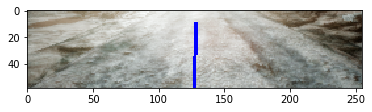

Actual Steering Angle = [-0.11475967]
Predicted Steering Angle = [-0.11257605]
L1 Error: [0.00218361]


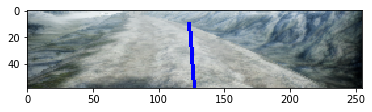

Actual Steering Angle = [0.18671367]
Predicted Steering Angle = [0.17970274]
L1 Error: [0.00701092]


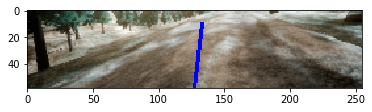

In [9]:
[sample_batch_train_data, sample_batch_test_data] = next(train_generator)
predictions = model.predict([sample_batch_train_data[0], sample_batch_train_data[1]])
for i in range(0, 3, 1):
    draw_image_with_label(sample_batch_train_data[0][i], sample_batch_test_data[i], predictions[i])

看起来不错!让我们继续在[下一个笔记本](TestModel.ipynb)中使用AirSim实际运行模型。